## Visualização do Dataset KITTI

In [1]:
# Import libraries
import os
import sys
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
%matplotlib inline
cv2.cuda.getCudaEnabledDeviceCount()

0

In [2]:
# Load config.json file
config = json.load(open('./config.json'))
KITTI_path = config["KITTI"]["path"]
sequences_path  = KITTI_path + config["KITTI"]["sequences path"]
poses_path      = KITTI_path + config["KITTI"]["poses_path"]
num_sequences   = config["KITTI"]["num_sequences"]
num_poses       = config["KITTI"]["num_poses"]

print("KITTI path: ", KITTI_path)
print("Sequences path: ", sequences_path)
print("Poses path: ", poses_path)
print("Number of sequences: ", num_sequences)
print("Number of poses: ", num_poses)

KITTI path:  ~/Documentos/RoboCIn/datasets/data_odometry_gray/dataset
Sequences path:  ~/Documentos/RoboCIn/datasets/data_odometry_gray/dataset/sequences
Poses path:  ~/Documentos/RoboCIn/datasets/data_odometry_gray/dataset/poses
Number of sequences:  21
Number of poses:  11


In [3]:
# Load poses
poses = [pd.read_csv('{}/{:02}.txt'.format(poses_path, i), delimiter=' ', header=None) for i in range(num_poses)]
poses[0].head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [4]:
# We load the ground truth poses into a list of numpy arrays
# Then, we do the dot product between the poses and (0, 0, 0, 1) to get the 
# postiion of the camera in relation to it's first position (0, 0, 0)

gt = []
for i in range(len(poses)):
    gt.append(np.zeros((len(poses[i]), 3, 4)))
    for j in range(len(poses[i])):
        gt[i][j] = np.array(poses[i].iloc[j]).reshape((3, 4))

gtv = []
for i in range(len(poses)):
    gtv.append(np.zeros((len(poses[i]), 3)))
    for j in range(len(poses[i])):
        gtv[i][j] = gt[i][j].dot(np.array([0,0,0,1]))

print(gt[0][1].dot(np.array([0,0,0,1])))
print(gt[0][1])

[-0.04690294 -0.02839928  0.8586941 ]
[[ 9.999978e-01  5.272628e-04 -2.066935e-03 -4.690294e-02]
 [-5.296506e-04  9.999992e-01 -1.154865e-03 -2.839928e-02]
 [ 2.066324e-03  1.155958e-03  9.999971e-01  8.586941e-01]]


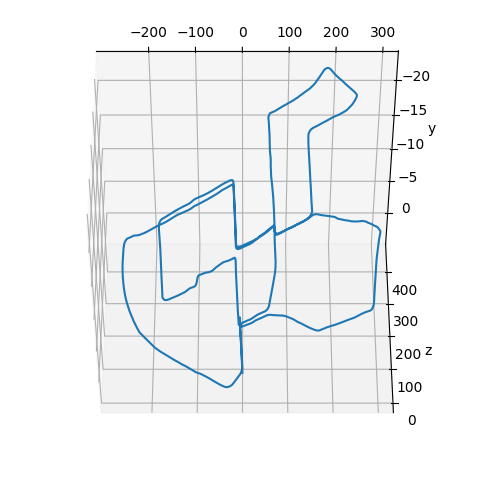

In [5]:
# Trajectory demonstration

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gtv[0][:,0], gtv[0][:,1], gtv[0][:,2], label='Ground Truth')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev = -40, azim = 270)

### Demonstração da relação entre coordenadas em pixel $u, v$ e coordenadas em metros $x, y, z$.
- $\lambda = $ escala de profundidade.
- $K = $ matriz de calibração intrínseca.
- $R = $ matriz de rotação.
- $t = $ vetor de translação.

![Projection Matrix](../resources/intrinsic_extrinsic.png)

In [6]:
cb = pd.read_csv(sequences_path + '/00/calib.txt', delimiter=' ', header=None, index_col=0)
cb.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [7]:
ti = pd.read_csv(sequences_path + '/00/times.txt', delimiter=' ', header=None, index_col=0)
ti.head()

""
0
0.000000
0.103736
0.207338
0.311075
0.414692


In [8]:
# Read calibration and times files for each sequence
camera_calib = []
time_stamps  = []
for i in range(num_sequences):
    cb = pd.read_csv(sequences_path + '/{:02}/calib.txt'.format(i), delimiter=' ', header=None, index_col=0).loc['P0:']
    ti = pd.read_csv(sequences_path + '/{:02}/times.txt'.format(i), delimiter=' ', header=None)
    camera_calib.append(np.array(cb).reshape((3, 4))[0:3, 0:3])
    time_stamps.append(np.array(ti))
camera_calib = np.array(camera_calib)

In [9]:
import main
seq_name = '00'
seq_idx  = int(seq_name)
preffered_direction = 2
main.run_KITTI_visual_odometry(sequences_path, seq_name, seq_idx, gt[seq_idx], camera_calib[seq_idx], time_stamps[seq_idx], preffered_direction)

0.8593272951343508 1
0.8593272951343508 2
0.8604375314945432 1


QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread (0x32a9a40).
Cannot move to target thread (0x3e40b40)

QObject::moveToThread: Current thread (0x3e40b40) is not the object's thread

0.8604375314945432 2
0.8594303561549744 1
0.8594303561549744 2
0.8604352755739623 1
0.8604352755739623 2
0.8593980295193723 1
0.8593980295193723 2
0.8605382312593032 1
0.8605382312593032 2
0.8594458686079657 1
0.8594458686079657 2
0.8603064855493124 1
0.8603064855493124 2
0.8605979454453111 1
0.8605979454453111 2
0.8591338309164989 1
0.8591338309164989 2
0.8604323432237826 1
0.8604323432237826 2
0.8603570585825695 1
0.8603570585825695 2
0.8595925592571222 1
0.8595925592571222 2
0.8558709757184264 1
0.8558709757184264 2
0.8636670402163615 1
0.8636670402163615 2
0.8707243304701037 1
0.8707243304701037 2
0.8816147302827979 1
0.8816147302827979 2
0.8919222529251115 1
0.8919222529251115 2
0.9017212569254713 1
0.9017212569254713 2
0.9061650813918662 1
0.9061650813918662 2
0.9130454314025128 1
0.9130454314025128 2
0.9151001350739488 1
0.9151001350739488 2
0.9185072472037503 1
0.9185072472037503 2
0.9286963158188442 1
0.9286963158188442 2
0.9361470997125162 1
0.9361470997125162 2
0.93733312182

SystemExit: 

/home/davi/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
